In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import healpy as hp
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tqdm import *
from iminuit import Minuit, describe, Struct

# My Functions
import AssortedFunctions
from AssortedFunctions import myLog
import InverseTransform
import PointSource
import PowerLaw

# Siddharth and Laura's Stuff
from NPTFit import create_mask as cm
import constants_noh as constants
import units

In [2]:
trials = 100
channel = 'b'
Nb = 1
xsec = 1e-25
marr = [100]
ebins = [.1,100]

In [3]:
# Setting basic parameters
nside = 128
npix = hp.nside2npix(nside)
   
pscmask=np.array(np.load('fermi_data/fermidata_pscmask.npy'), dtype=bool)
exposure=np.array(np.load('fermi_data/fermidata_exposure.npy'))
mask = cm.make_mask_total(mask_ring = False)
area_rat = (len(mask[~mask]))/len(mask)

In [4]:
# Defining some constants
r_s = 0.65*311 # scale radius, [kpc]
alpha = 2.20
N_calib = 300. # Number of subhalos with masses 10^8 - 10^10 M_sun
M_MW = 1.1e12 # [M_s]
mMin_calib = 1e8 # [M_s]
mMax_calib = 1e10 # [M_s]
mMin = 5e6
mMax_arr = np.array([1e10]) #, .01*M_MW, M_MW]) # [M_s]
min_flux =np.log10(1./(np.sum(exposure[~mask])/len(exposure[~mask])))

In [5]:
def dNdm_func(m): # Subhalo mass function
    norm = N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9)))
    return norm * (m)**(-1.9)

N_subs_arr= []
for mMax in mMax_arr:
    N_subs_arr.append(round(N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9))) * -.9**(-1) * (mMax**(-.9) - mMin**(-.9)))) # Total number of subhalos
#N_subs_arr = (np.random.poisson(N_subs_arr)).astype(int)
print(N_subs_arr)
N_subs_arr = (np.ones(len(N_subs_arr))*800).astype(int)
def mCDFInv(r):
    return ( m_arr[0]**(-.9) - (m_arr[0]**(-.9) - m_arr[-1]**(-.9))*r )**(-1/.9)

rho_s2 = 1. #float(N_subs) / quad(lambda x: 4 * np.pi * x**2 * np.exp( -2./alpha * ( (x/r_s)**(alpha) - 1)), 0, constants.r_vir)[0]
def rho_Ein(r): # Einasto density Profile
    return rho_s2 * np.exp( (-2./alpha) * ( (r/r_s)**(alpha) - 1))

def conc(m200, r, r200):
    a = -5.384
    b = 1.156
    c = -0.056
    rmax = 10**( a + b*np.log10(m200/units.M_s) + c*(np.log10(m200/units.M_s)**2) )*units.kpc
    return r200 / (rmax/2.189)
print(conc(1e10*units.M_s, 1, 2*units.kpc))

[4514.0]
1.1621863150328968


In [6]:
%%capture
F_Mmax = []
for im, mMax in enumerate(mMax_arr):
    r_arr = np.logspace(0, np.log10(2000), 60500) # radius values to test
    r_sampler = InverseTransform.InverseTransform(lambda r: r**2 * rho_Ein(r), r_arr, nsamples=(N_subs_arr[im]))
    m_arr = np.logspace(np.log10(mMin), np.log10(mMax), 80000) # mass values to test
    m_sampler = InverseTransform.InverseTransform(dNdm_func, m_arr, nsamples=(N_subs_arr[im]), cdfinv=mCDFInv)

    PS_arr = []
    F_arr = []
    flux_bins = np.logspace(-15, -6, 20)

    for i in tqdm_notebook(range(trials)):
        rval_arr = r_sampler.sample()
        mval_arr = m_sampler.sample()

        theta_arr = (np.arccos(2*np.random.rand(N_subs_arr[im])-1))
        phi_arr = (2*np.pi*np.random.rand(N_subs_arr[im]))

        PS_set = PointSource.PointSource(mval_arr, rval_arr, theta_arr, phi_arr)
        PS_set.calcJ("", concFunc=conc)

        truth_arr = np.ones(len(PS_set.Mvir))#np.array(.4733 * PS_set.Mvir/units.M_s / ( np.log(1+PS_set.c) - PS_set.c / (1 + PS_set.c ) ) > 16*2.8*340/(4.3e-3))
        PS_arr.append(PS_set)
        if i == 0: 
            PPnoxsec = PS_set.PPnoxsec(marr[0], ebins, channel, energy=False)
            #PPnoxsec = quad( lambda E: K * (E/E0)**(-Gamma) * np.exp(-(E/Ecut)**(beta)), 100, 100000 )[0] * 8 * np.pi * marr[0]**2
        F_arr.append(np.histogram(PS_set.J.value[~mask[PS_set.pixels]] * xsec * PPnoxsec, bins=flux_bins)[0])
    F_Mmax.append(F_arr)

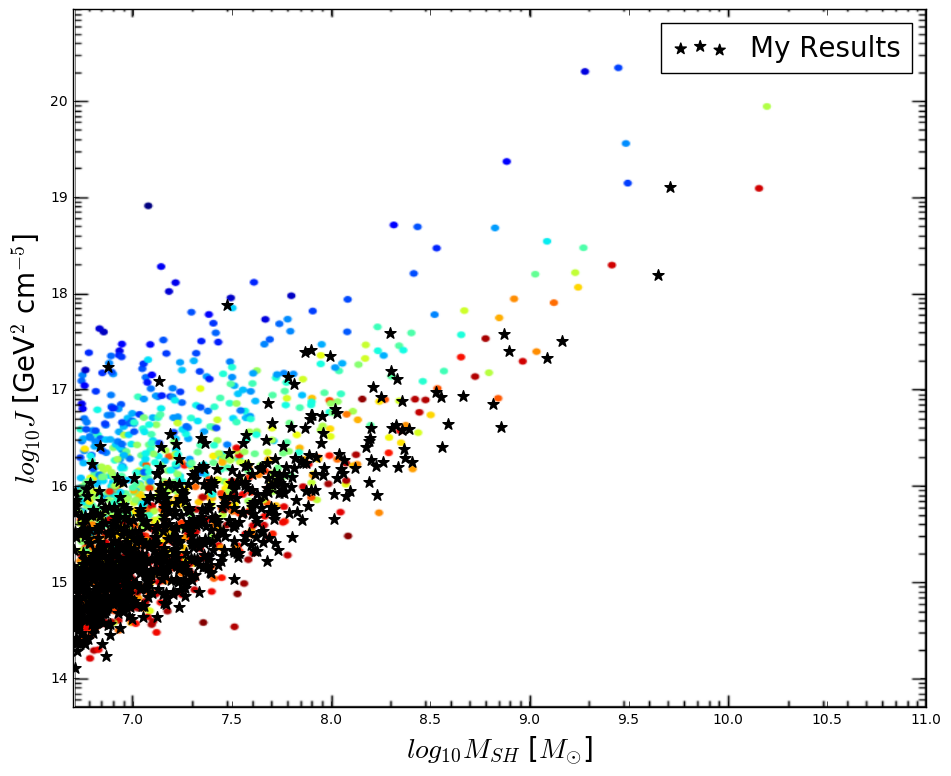

In [7]:
plt.figure(figsize=(11,9))
img = plt.imread("../161103053.png")
plt.imshow(img, extent=[6.71,11, 13.69,20.98], aspect='auto')
cm = plt.cm.get_cmap('hsv')
#plt.scatter(np.log10(PS_set.Mvir[~mask[PS_set.pixels]]/units.M_s), np.log10(PS_set.J.value[~mask[PS_set.pixels]]), c=PS_set.coord.distance.value[~mask[PS_set.pixels]], s=10, cmap=cm, alpha=1)
plt.scatter(np.log10(PS_set.Mvir[~mask[PS_set.pixels]]/units.M_s), np.log10(PS_set.J.value[~mask[PS_set.pixels]]), s=70, alpha=1, c="black", marker="*", label="My Results")
#plt.colorbar()
plt.ylabel("$log_{10} J$ [GeV$^2$ cm$^{-5}$]", fontsize=20)
plt.xlabel("$log_{10} M_{SH}$ [$M_{\odot}$]", fontsize=20)
plt.ylim(13.7, 20.96)
plt.xlim(6.7, 11)
plt.legend(fontsize=20)

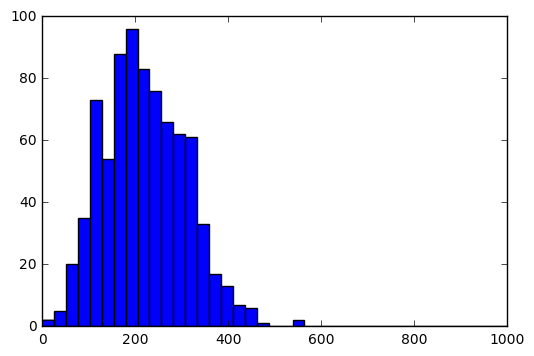

In [8]:
plt.hist(rval_arr, np.linspace(0,1000,40));

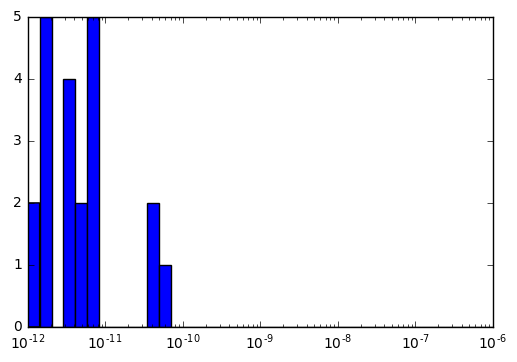

In [9]:
plt.hist(xsec*PPnoxsec*PS_arr[9].J.value[~mask[PS_set.pixels]], bins=np.logspace(-12,-6,40));
plt.xscale("log")

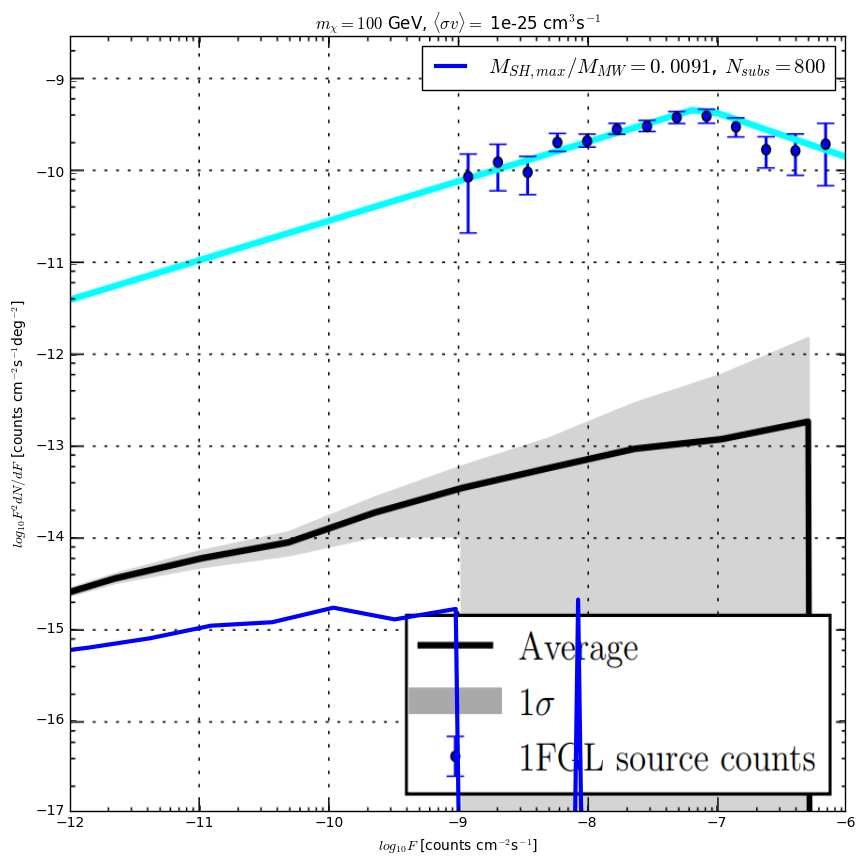

In [10]:
plt.figure(figsize=(10,10))
img = plt.imread("../161103503.png")
plt.imshow(img, extent=[-12,-6, -17,-8.5], aspect='auto')

for mi, F_arr in enumerate(F_Mmax):
    min_flux_ind = np.argmin(np.abs(flux_bins - 0)) #10.**(min_flux)))
    flux_bins2 = flux_bins[min_flux_ind:]
    F_arr = np.array(F_arr).astype(float)
    for i in range(len(F_arr)):
        F_arr[i][F_arr[i]==0] = 1e-50
    F_ave = (np.mean(F_arr, axis=0))[min_flux_ind:]
    max_flux = np.log10(flux_bins2[np.argmax(F_ave < 1e-20)])

    dF = np.diff(flux_bins2)
    dN = np.array(F_ave)/(4*np.pi*(180/np.pi)**2*area_rat)
    F = (np.array(flux_bins2)[:-1]+np.array(flux_bins2)[1:])/2.

    plt.plot(myLog(F), myLog(F**2*dN/dF), linewidth=3, label="$M_{SH,max}/M_{MW} = "+str(round(mMax_arr[mi]/M_MW, 4))+"$, $N_{subs}="+str(N_subs_arr[mi])+"$")
plt.xlim(-12, -6)
plt.ylim(-17, -8.5)
plt.title("$m_{\chi} = "+str(marr[0])+"$ GeV, $\\langle \sigma v \\rangle =$ "+str(xsec)+" cm$^3$s$^{-1}$")
plt.ylabel("$log_{10} F^2dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]")
plt.xlabel("$log_{10} F$ [counts cm$^{-2}$s$^{-1}$]")
plt.legend(fontsize=15)
plt.show()
plt.close()

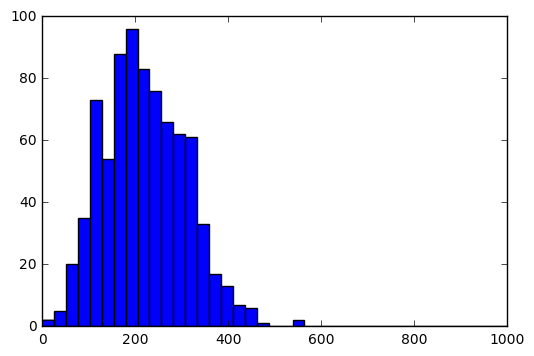

In [11]:
plt.hist(rval_arr, np.linspace(0,1000,40));

In [12]:
F_test = np.logspace(-13.1, -6, 10000)
print(np.trapz(10**(-10.4)*F_test**(0.35-2), F_test)*(4*np.pi*(180/np.pi)**2*area_rat))
print(10**(-10.4)*F_test**(0.35-2))

827.0497914351922
[1.64058977e+11 1.63616984e+11 1.63176181e+11 ... 3.17938583e-01
 3.17082021e-01 3.16227766e-01]


0.0006534147086029582
1.288576867632832e-10


(1e-12, 2e-06)

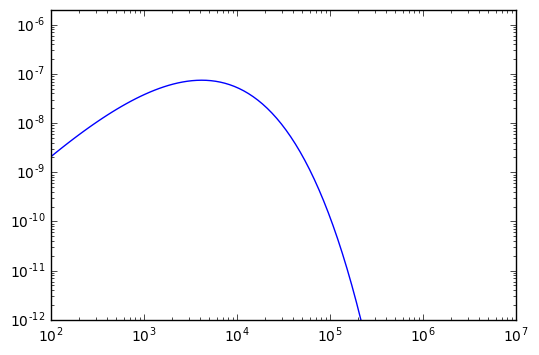

In [13]:
K = 6.552e-13
E0 = 1e3
Gamma = 0.000
Ecut = 7.196e1
beta = 0.398
print(5*PPnoxsec)
print( quad( lambda E: K * (E/E0)**(-Gamma) * np.exp(-(E/Ecut)**(beta)), 100, 100000 )[0])
E = np.logspace(2,7,100)
plt.plot(E, K * (E/E0)**(-Gamma) * np.exp(-(E/Ecut)**(beta)) * E**2)
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e2, 1e7)
plt.ylim(1e-12, 2e-6)

(1e-15, 1e-06)

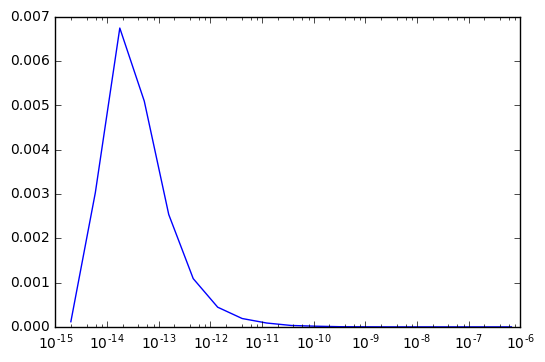

In [14]:
plt.plot(F, dN)
#plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-15, 1e-6)
#plt.ylim(0, 0.00010)

In [15]:
print(xsec)

1e-25
